# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


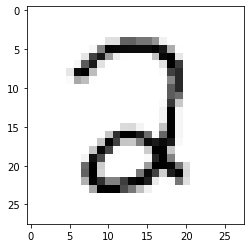

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2482
Training Accuracy: 0.5302, Testing Accuracy: 0.5272



Epoch 10, Loss 0.1003
Training Accuracy: 0.9181, Testing Accuracy: 0.9299



Epoch 20, Loss 0.0585
Training Accuracy: 0.9413, Testing Accuracy: 0.9471



Epoch 30, Loss 0.0454
Training Accuracy: 0.9510, Testing Accuracy: 0.9551



Epoch 40, Loss 0.0391
Training Accuracy: 0.9556, Testing Accuracy: 0.9597



Epoch 50, Loss 0.0354
Training Accuracy: 0.9579, Testing Accuracy: 0.9652



Epoch 60, Loss 0.0329
Training Accuracy: 0.9604, Testing Accuracy: 0.9657



Epoch 70, Loss 0.0311
Training Accuracy: 0.9638, Testing Accuracy: 0.9667



Epoch 80, Loss 0.0296
Training Accuracy: 0.9657, Testing Accuracy: 0.9693



Epoch 90, Loss 0.0284
Training Accuracy: 0.9670, Testing Accuracy: 0.9708



Epoch 100, Loss 0.0274
Training Accuracy: 0.9677, Testing Accuracy: 0.9708



Epoch 110, Loss 0.0265
Training Accuracy: 0.9688, Testing Accuracy: 0.9713



Epoch 120, Loss 0.0257
Training Accuracy: 0.9697, Testing Accuracy: 0.9713



Epoch 130, Loss 0.025
Training Accuracy: 0.9706, Testing Accuracy: 0.9708



Epoch 140, Loss 0.0243
Training Accuracy: 0.9713, Testing Accuracy: 0.9703



Epoch 150, Loss 0.0237
Training Accuracy: 0.9721, Testing Accuracy: 0.9718



Epoch 160, Loss 0.0232
Training Accuracy: 0.9731, Testing Accuracy: 0.9718



Epoch 170, Loss 0.0226
Training Accuracy: 0.9737, Testing Accuracy: 0.9723



Epoch 180, Loss 0.0221
Training Accuracy: 0.9740, Testing Accuracy: 0.9728



Epoch 190, Loss 0.0216
Training Accuracy: 0.9747, Testing Accuracy: 0.9728



Epoch 200, Loss 0.0212
Training Accuracy: 0.9755, Testing Accuracy: 0.9733



Epoch 210, Loss 0.0207
Training Accuracy: 0.9763, Testing Accuracy: 0.9738



Epoch 220, Loss 0.0203
Training Accuracy: 0.9770, Testing Accuracy: 0.9738



Epoch 230, Loss 0.0199
Training Accuracy: 0.9776, Testing Accuracy: 0.9748



Epoch 240, Loss 0.0195
Training Accuracy: 0.9785, Testing Accuracy: 0.9758



0.0026578992794443713

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2266
Training Accuracy: 0.7408, Testing Accuracy: 0.7429



Epoch 10, Loss 0.1008
Training Accuracy: 0.9127, Testing Accuracy: 0.9244



Epoch 20, Loss 0.0785
Training Accuracy: 0.9278, Testing Accuracy: 0.9385



Epoch 30, Loss 0.068
Training Accuracy: 0.9352, Testing Accuracy: 0.9461



Epoch 40, Loss 0.0617
Training Accuracy: 0.9401, Testing Accuracy: 0.9536



Epoch 50, Loss 0.0573
Training Accuracy: 0.9431, Testing Accuracy: 0.9556



Epoch 60, Loss 0.0541
Training Accuracy: 0.9461, Testing Accuracy: 0.9572



Epoch 70, Loss 0.0516
Training Accuracy: 0.9483, Testing Accuracy: 0.9587



Epoch 80, Loss 0.0495
Training Accuracy: 0.9507, Testing Accuracy: 0.9597



Epoch 90, Loss 0.0478
Training Accuracy: 0.9522, Testing Accuracy: 0.9602



Epoch 100, Loss 0.0464
Training Accuracy: 0.9527, Testing Accuracy: 0.9597



Epoch 110, Loss 0.0452
Training Accuracy: 0.9528, Testing Accuracy: 0.9607



Epoch 120, Loss 0.0441
Training Accuracy: 0.9540, Testing Accuracy: 0.9617



Epoch 130, Loss 0.0432
Training Accuracy: 0.9548, Testing Accuracy: 0.9622



Epoch 140, Loss 0.0424
Training Accuracy: 0.9557, Testing Accuracy: 0.9622



Epoch 150, Loss 0.0416
Training Accuracy: 0.9565, Testing Accuracy: 0.9632



Epoch 160, Loss 0.0409
Training Accuracy: 0.9571, Testing Accuracy: 0.9632



Epoch 170, Loss 0.0403
Training Accuracy: 0.9575, Testing Accuracy: 0.9632



Epoch 180, Loss 0.0397
Training Accuracy: 0.9579, Testing Accuracy: 0.9637



Epoch 190, Loss 0.0392
Training Accuracy: 0.9582, Testing Accuracy: 0.9637



Epoch 200, Loss 0.0387
Training Accuracy: 0.9589, Testing Accuracy: 0.9647



Epoch 210, Loss 0.0383
Training Accuracy: 0.9590, Testing Accuracy: 0.9652



Epoch 220, Loss 0.0379
Training Accuracy: 0.9595, Testing Accuracy: 0.9652



Epoch 230, Loss 0.0375
Training Accuracy: 0.9596, Testing Accuracy: 0.9657



Epoch 240, Loss 0.0371
Training Accuracy: 0.9597, Testing Accuracy: 0.9662



0.0443438483825744

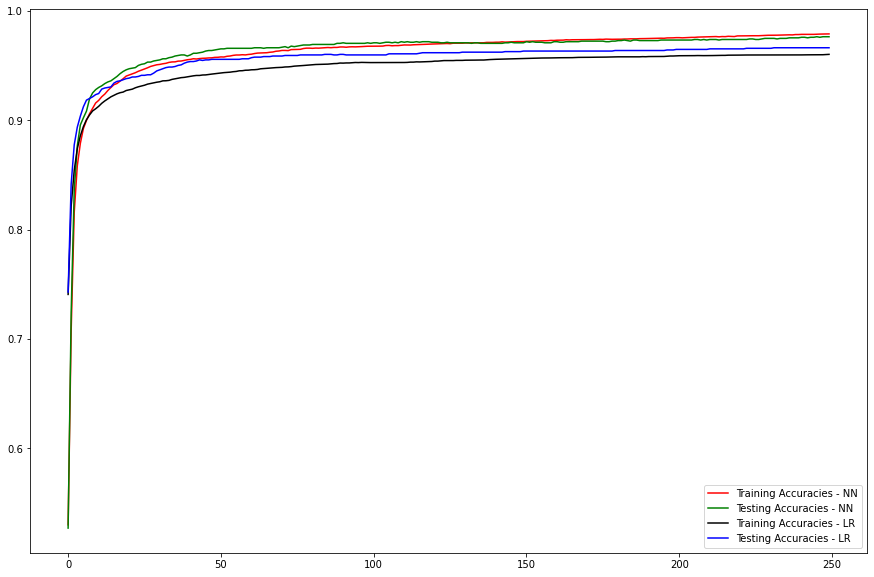

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

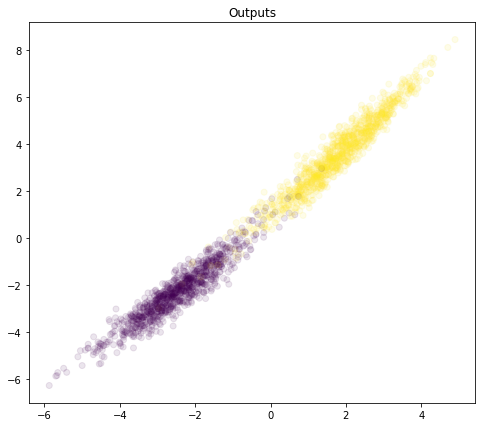

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

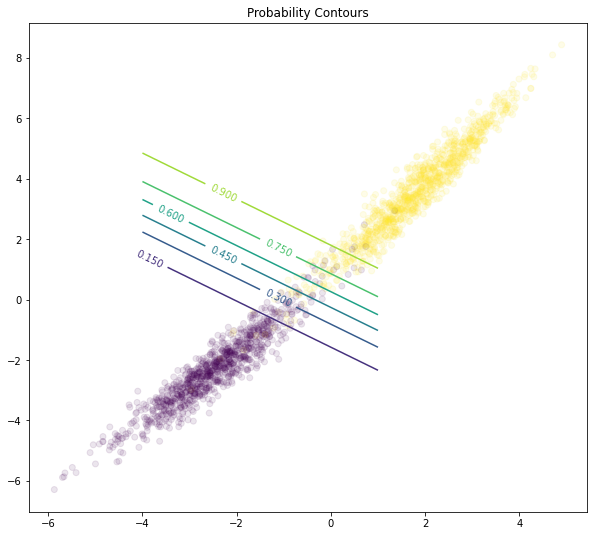

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );